In [1]:
# data analysis imports
import time
import datetime
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from MCForecastTools import MCSimulation

# API imports
import json
import requests
import alpaca_trade_api
from alpaca_trade_api.rest import TimeFrame
from dotenv import find_dotenv, get_key

---

Alternative.me's Free Crypto API (https://alternative.me/crypto/api/)

In [2]:
BASE_URL = 'https://api.alternative.me/v2/'

def get_crypto_listing ():
    """
    From the website: Overview of all available crypto currencies,
    use the returned id to retrieve more data on a specific crypto currency on the ticker endpoint.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}listings/').json()
    
    df = pd.DataFrame(json_response['data'])
    
    df = df[[                # reorder columns
        'name',
        'symbol',
        'website_slug',
        'id',
    ]]
    df = df.rename(columns={ # rename columns
        'id': 'api_id',
    })
    
    return df, json_response['metadata']

def get_crypto_tickers ():
    """
    From the website: Coin and token prices updated every 5 minutes.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}ticker/?limit=0').json()
    
    df = pd.DataFrame(json_response['data'])
    df = df.T
    df = df.set_index(pd.RangeIndex(len(json_response['data'])))
    
    quotes_df = pd.json_normalize(df['quotes'])
    df = pd.concat([df, quotes_df], axis=1)
    
    df = df[[                               # reorder columns
        'name',
        'symbol',
        'rank',
        'USD.market_cap',
        'last_updated',
        'USD.price',
        'USD.volume_24h',
        'USD.percent_change_1h',
        'USD.percent_change_24h',
        'USD.percent_change_7d',
        'id',
    ]]
    df = df.rename(columns={                # rename columns
        'rank': 'market_cap_rank',
        'last_updated': 'last_updated_UTC',
        'id': 'api_id',
    })
    
    df['last_updated_UTC'] = pd.to_datetime(df['last_updated_UTC'], unit='s')
    
    return df, json_response['metadata']

def get_crypto_global ():
    """
    From the website: Get global market information at a glance.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}global/').json()
    
    df = pd.DataFrame(json_response['data'])
    df = df.set_index(pd.RangeIndex(1))
    
    quotes_df = pd.json_normalize(df['quotes'])
    df = pd.concat([df, quotes_df], axis=1)
    
    df = df[[                               # reorder columns
        'active_cryptocurrencies',
        'active_markets',
        'bitcoin_percentage_of_market_cap',
        'last_updated',
        'total_market_cap',
        'total_volume_24h',
    ]]
    df = df.rename(columns={                # rename columns
        'last_updated': 'last_updated_UTC',
    })
    
    df['last_updated_UTC'] = pd.to_datetime(df['last_updated_UTC'], unit='s')
    
    return df.T, json_response['metadata']

In [3]:
global_df, global_meta = get_crypto_global()
global_df[0]

active_cryptocurrencies                            1301
active_markets                                       20
bitcoin_percentage_of_market_cap                0.47495
last_updated_UTC                    2021-05-13 20:05:14
total_market_cap                          1919393232036
total_volume_24h                           644563928117
Name: 0, dtype: object

In [4]:
listings_df, listings_meta = get_crypto_listing()
listings_meta

{'timestamp': 1620936320, 'num_cryptocurrencies': 1301, 'error': None}

In [5]:
listings_df.head()

,name,symbol,website_slug,api_id
0,Bitcoin,BTC,bitcoin,1
1,Litecoin,LTC,litecoin,2
2,Namecoin,NMC,namecoin,3
3,Terracoin,TRC,terracoin,4
4,Peercoin,PPC,peercoin,5


In [6]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          1301 non-null   object
 1   symbol        1301 non-null   object
 2   website_slug  1301 non-null   object
 3   api_id        1301 non-null   object
dtypes: object(4)
memory usage: 40.8+ KB


In [7]:
tickers_df, tickers_meta = get_crypto_tickers()
tickers_meta

{'timestamp': 1620411445, 'num_cryptocurrencies': 1301, 'error': None}

In [8]:
tickers_df.head(5)

,name,symbol,market_cap_rank,USD.market_cap,last_updated_UTC,USD.price,USD.volume_24h,USD.percent_change_1h,USD.percent_change_24h,USD.percent_change_7d,api_id
0,Bitcoin,BTC,1,911616482462,2021-05-13 20:00:33,48710.00,110307806153,1.249185,-10.831957,-15.186919,1
1,Ethereum,ETH,2,424613240080,2021-05-13 20:01:24,3671.26,103360144787,1.538632,-10.473776,4.162007,1027
2,Binance Coin,BNB,3,85137771061,2021-05-13 20:01:48,551.30,9605007125,-0.000232,-14.309001,-15.422727,1839
3,Cardano,ADA,4,59760349310,2021-05-13 20:04:58,1.86,13738401618,-0.915932,8.731404,25.893824,2010
4,XRP,XRP,5,57941705406,2021-05-13 20:04:29,1.26,11929052127,0.730055,-10.299603,-21.912568,52


In [9]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    500 non-null    object        
 1   symbol                  500 non-null    object        
 2   market_cap_rank         500 non-null    object        
 3   USD.market_cap          500 non-null    int64         
 4   last_updated_UTC        500 non-null    datetime64[ns]
 5   USD.price               500 non-null    float64       
 6   USD.volume_24h          500 non-null    int64         
 7   USD.percent_change_1h   474 non-null    float64       
 8   USD.percent_change_24h  486 non-null    float64       
 9   USD.percent_change_7d   494 non-null    float64       
 10  api_id                  500 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 43.1+ KB


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (500).

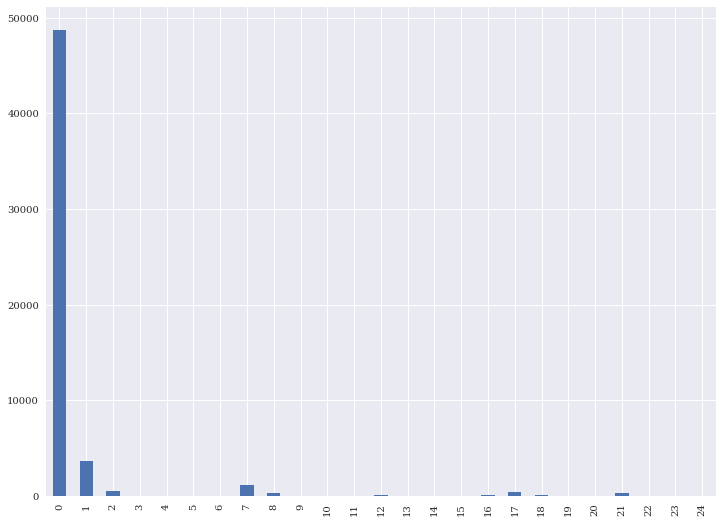

In [10]:
ax = tickers_df['USD.price'].head(25).plot.bar(figsize=(12, 9));
ax.set_xticklabels(tickers_df['name']);

---

In [11]:
today = pd.Timestamp(datetime.date.today(), tz='America/New_York').isoformat()
now   = pd.Timestamp(datetime.datetime.now(), tz='America/New_York').isoformat()
# (datetime.datetime(2016, 5, 1) - datetime.datetime(2021, 3, 1)).days / 365.25

In [12]:
# Alpaca Markets credentials
alpaca_api_key = get_key(find_dotenv(), 'ALPACA_API_KEY')
alpaca_secret_key = get_key(find_dotenv(), 'ALPACA_SECRET_KEY')

In [13]:
# Alpaca Markets Client SDK
# GitHub: https://github.com/alpacahq/alpaca-trade-api-python
# PyPI: https://pypi.org/project/alpaca-trade-api/

# initialization
alpaca = alpaca_trade_api.rest.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2',
)

def get_bars_sdk (symbol):
    df = alpaca.get_bars(
        symbol,
        TimeFrame.Day,
        '2021-04-01',
        '2021-04-01',
        limit=10_000,
    ).df
    df['symbol'] = symbol
    return df

"""
alpaca.get_bars(
    'AAPL',
    TimeFrame.Minute,
    '2021-02-08',
    '2021-02-08',
    limit=10,
    adjustment='raw',
).df
""";

In [14]:
# Alpaca Markets API
BASE_URL_HIST = 'https://data.alpaca.markets/v2/'
BASE_URL_PAPR = 'https://paper-api.alpaca.markets/v2/'
KEYS = {'APCA-API-KEY-ID': alpaca_api_key, 'APCA-API-SECRET-KEY': alpaca_secret_key,}

start = '2016-05-01'
end   = '2021-04-01'

def get_account ():
    json_response = requests.get(
        f'{BASE_URL_PAPR}account',
        headers=KEYS,
    ).json()
    return json_response
def create_order (symbol, qty, side, typ, time_in_force):
    data = {
        'symbol': symbol,
        'qty': qty,
        'side': side,
        'type': typ,
        'time_in_force': time_in_force,
    }
    json_response = requests.post(
        f'{BASE_URL_PAPR}orders',
        json=data,
        headers=KEYS,
    ).json()
    return json_response
#create_order('MSFT', 1000, 'buy', 'market', 'gtc')
def get_orders ():
    json_response = requests.get(
        f'{BASE_URL_PAPR}orders',
        headers=KEYS,
    ).json()
    return json_response


def get_historical_trades (symbol, start=start, end=end, limit=10_000):
    params = {
        'start': start,
        'end': end,
        'limit': limit,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/trades',
        params=params,
        headers=KEYS,
    ).json()
    return json_response

def get_historical_quotes (symbol, start=start, end=end, limit=10_000):
    """
    From the website: The quotes API provides NBBO quotes for a given ticker symbol at a specified date.
    """
    params = {
        'start': start,
        'end': end,
        'limit': limit,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/quotes',
        params=params,
        headers=KEYS,
    ).json()
    return json_response

def get_historical_bars (symbol='AAPL', start=start, end=end, limit=10_000, timeframe='1Day', page_token=None):
    """
    The bars API returns aggregate historical data for the requested securities.
    """
    params = {
        'start': start,
        'end': end,
        'limit': limit,
        'timeframe': timeframe,
        'page_token': page_token,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/bars',
        params=params,
        headers=KEYS,
    ).json()
    
    df = pd.DataFrame.from_dict(json_response['bars']).rename(columns={
        't': 'Datetime',
        'o': 'Open Price',
        'h': 'High Price',
        'l': 'Low Price',
        'c': 'Close Price',
        'v': 'Volume',
    })
    df = df.set_index('Datetime')
    df.index = pd.DatetimeIndex(df.index)
    
    df = df.set_index(
        pd.MultiIndex.from_arrays(
            [df.index.year, df.index.month, df.index.day],
            names=['year', 'month', 'day']
        )
    )
    #df = df.groupby([df.index.year, df.index.month, df.index.day]).first()
    
    return df

In [ ]:
#get_historical_bars('SPY')

In [ ]:
#get_historical_bars('SPY')[['Open Price', 'Close Price']].plot(figsize=(12, 9));

---
# Personal Finance

#### Assets

In [15]:
avg_monthly_income = 12_000
emerg_fund_thresh  = avg_monthly_income * 3

portfolio = pd.DataFrame({
    'BTC': 1.2,
    'ETH': 5.3,
    'SPY': 50,
    'AGG': 200,
}, index=['assets'])
portfolio = portfolio.T
portfolio['class'] = ['crypto'] * 2 + ['shares'] * 2
portfolio

,assets,class
BTC,1.2,crypto
ETH,5.3,crypto
SPY,50.0,shares
AGG,200.0,shares


In [16]:
prices = []
btc_price = tickers_df[tickers_df['symbol']=='BTC'].values[0, 5] # get the current price of Bitcoin
  #requests.get(f'{BASE_URL}ticker/bitcoin/').json()['data']['1']['quotes']['USD']['price']
prices.append(btc_price)
eth_price = tickers_df[tickers_df['symbol']=='ETH'].values[0, 5] # get the current price of Ethereum
  #requests.get(f'{BASE_URL}ticker/ethereum/').json()['data']['1027']['quotes']['USD']['price']
prices.append(eth_price)
spy_price = get_bars_sdk('SPY').values[0, 3]
prices.append(spy_price)
agg_price = get_bars_sdk('AGG').values[0, 3]
prices.append(agg_price)
prices

HTTPError: 403 Client Error: Forbidden for url: https://data.alpaca.markets/v2/stocks/SPY/bars?timeframe=1Day&adjustment=raw&start=2021-04-01&end=2021-04-01&limit=10000

In [ ]:
portfolio['price'] = prices
portfolio

In [ ]:
portfolio['value'] = portfolio['assets'] * portfolio['price']
portfolio.style.format({'assets': '{:.1f}', 'price': '${:,.2f}', 'value': '${:,.2f}'})

In [ ]:
portfolio.plot.pie(y='value', title='Personal Savings', figsize=(12, 9));

In [ ]:
portfolio.groupby('class').sum().style.format({'assets': '{:.1f}', 'price': '${:,.2f}', 'value': '${:,.2f}'})

In [ ]:
portfolio[['value']].T.plot.barh(stacked=True, width=0.25, figsize=(12, 2));

In [ ]:
portfolio.groupby('class').sum()[['value']].T.plot.barh(stacked=True, width=0.25, figsize=(12, 2), color=['lightblue', 'darkblue']);

---

#### Emergency Fund

In [ ]:
total_savings = portfolio['value'].sum()
if total_savings >= emerg_fund_thresh:
    print(
        f'You have ${total_savings:,.2f} in savings.'
        f'\nYou\'re meeting your emergency fund threshold of ${emerg_fund_thresh:,.2f}!'
        f'\nYou\'re ${total_savings - emerg_fund_thresh:0,.2f} above your emergency fund threshold.'
    )
else:
    print(
        f'You have ${total_savings:,.2f} in savings.'
        f'\nYou\'re not meeting your emergency fund threshold of ${emerg_fund_thresh:,.2f}!'
        f'\nYou\'re ${emerg_fund_thresh - total_savings:0,.2f} below your emergency fund threshold.'
    )

---

# Retirement Planning

In [ ]:
# get the last five years of shares data
today      = pd.Timestamp(datetime.date.today(), tz='America/New_York').isoformat()
five_years = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=5*365.25), tz='America/New_York').isoformat()

In [ ]:
today

In [ ]:
five_years

In [ ]:
spy_df = alpaca.get_bars(
    'SPY',
    TimeFrame.Day,
    start='2016-05-01',
    end=today,
    limit=10_000,
).df
agg_df = alpaca.get_bars(
    'AGG',
    TimeFrame.Day,
    start='2016-05-01',
    end=today,
    limit=10_000,
).df
df = pd.concat([spy_df, agg_df], axis=1)
df.columns = pd.MultiIndex.from_tuples([(sym, col) for sym in ['SPY', 'AGG'] for col in ['open', 'high', 'low', 'close', 'volume']])
df.head(2)

In [ ]:
MC_thirty_year = MCSimulation(
    portfolio_data = df,
    weights = [0.4, 0.6],
    num_simulation = 500,
    num_trading_days = 252 * 30,
)
MC_thirty_year.portfolio_data.head()

In [ ]:
MC_thirty_year.calc_cumulative_return()

In [ ]:
MC_thirty_year.plot_simulation();

In [ ]:
MC_thirty_year.plot_distribution();

In [ ]:
table30 = MC_thirty_year.summarize_cumulative_return()
print(table30)

In [ ]:
initial_investment = 20_000
ci_lower = round(table30[8] * initial_investment, 2)
ci_upper = round(table30[9] * initial_investment, 2)
print(
    f'There is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
    f' over the next 30 years will be in the range of'
    f' ${ci_lower} and ${ci_upper}.'
)

In [ ]:
initial_investment = 20_000 * 1.5
ci_lower = round(table30[8] * initial_investment, 2)
ci_upper = round(table30[9] * initial_investment, 2)
print(
    f'There is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
    f' over the next 30 years will be in the range of'
    f' ${ci_lower} and ${ci_upper}.'
)

In [ ]:
MC_five_year = MCSimulation(
    portfolio_data = df,
    weights = [0.8, 0.2],
    num_simulation = 500,
    num_trading_days = 252 * 5,
)

In [ ]:
MC_five_year.calc_cumulative_return()

In [ ]:
MC_five_year.plot_simulation();

In [ ]:
MC_five_year.plot_distribution();

In [ ]:
table5 = MC_five_year.summarize_cumulative_return()
print(table5)

In [ ]:
initial_investment = 20_000 * 3
ci_lower = round(table5[8] * initial_investment, 2)
ci_upper = round(table5[9] * initial_investment, 2)
print(
    f'There is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
    f' over the next 5 years will be in the range of'
    f' ${ci_lower} and ${ci_upper}.'
)

In [ ]:
MC_ten_year = MCSimulation(
    portfolio_data = df,
    weights = [0.8, 0.2],
    num_simulation = 500,
    num_trading_days = 252 * 10,
)

In [ ]:
MC_ten_year.calc_cumulative_return()

In [ ]:
MC_ten_year.plot_simulation();

In [ ]:
MC_ten_year.plot_distribution();

In [ ]:
table10 = MC_ten_year.summarize_cumulative_return()
print(table10)

In [ ]:
initial_investment = 20_000 * 3
ci_lower = round(table5[8] * initial_investment, 2)
ci_upper = round(table5[9] * initial_investment, 2)
print(
    f'There is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
    f' over the next 10 years will be in the range of'
    f' ${ci_lower} and ${ci_upper}.'
)

---